### Loading the modules

In [ ]:
import pandas as pd
import os
!pip install tensorflow  # Ensure TensorFlow is installed
import tensorflow as tf

# Enable mixed precision
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/classes_NUS/Project_Module_2/archive/glaucoma.csv', sep=',')
df.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [ ]:
df.describe()

,ExpCDR,Glaucoma
count,650.000000,650.000000
mean,0.576308,0.258462
std,0.116395,0.438126
min,0.161000,0.000000
25%,0.496675,0.000000
50%,0.567650,0.000000
75%,0.648475,1.000000
max,0.962900,1.000000


### Pre-processing of glaucoma.csv to check if the data is imabalanced, and using appropriate data balancing technique

No of Glaucoma : 168
No of Non-Glaucoma : 482


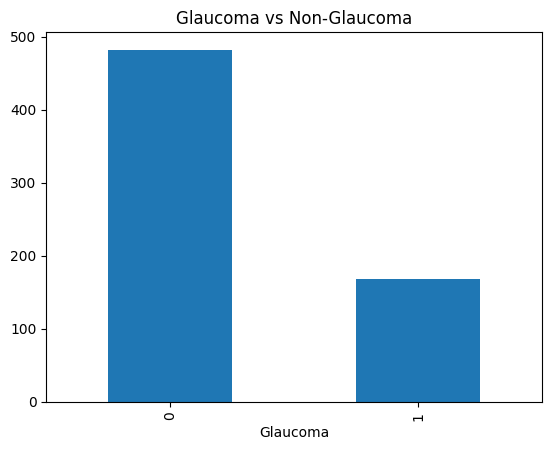

In [ ]:
# check if the data is imbalanced
class_counts = df['Glaucoma'].value_counts()
print(f"No of Glaucoma : {class_counts[1]}")
print(f"No of Non-Glaucoma : {class_counts[0]}")
class_counts.plot(kind='bar')
plt.title('Glaucoma vs Non-Glaucoma')
plt.show()

In [ ]:
ratio_label_0 = class_counts[0] / len(df)
ratio_label_1 = class_counts[1] / len(df)
print(f"Ratio of Glaucoma : {ratio_label_1}")
print(f"Ratio of Non-Glaucoma : {ratio_label_0}")
if ratio_label_0 > 0.7 or ratio_label_1 > 0.7:
  print("Data is imbalanced, so proceeding with data balancing method - Class weights")
  # since data is imbalanced, we can do undersampling, or oversampling or class weights methods for balancing the data set
  # the no of samples in the dataset is only 650, so insteas of removing , will use class weights or oversampling method
  # class_weights can be used during model training, these weights will help to mitigate the negative impact of the class imabalance
  class_weights = class_weight.compute_class_weight('balanced', classes = np.unique(df['Glaucoma']), y = df['Glaucoma'])
  class_weights = dict(enumerate(class_weights))
  print(f"Class Weights : {class_weights}")
else:
  print("Data is balanced")

Ratio of Glaucoma : 0.25846153846153846
Ratio of Non-Glaucoma : 0.7415384615384616
Data is imbalanced, so proceeding with data balancing method - Class weights
Class Weights : {0: 0.6742738589211619, 1: 1.9345238095238095}


### Function : target_input_size_model()  to set target size and input size based on model type


In [ ]:
#set the target image size based on base model used
def target_input_size_model(model_type='ENB7'):
  if model_type == 'ENB7':
    target_size = (600,600) # recommended target size for this base model
    input_shape = (600,600,3)
  elif model_type == 'MBV3' or model_type == 'RN' or model_type == 'DN':
    target_size = (224,224) # recommended target size for these two base models
    input_shape = (224,224,3)
  return target_size, input_shape

### Function : load_images_from_folder_model_specific() - load images from remote file location - the load_images_from_folder api is memory intensive - Not to be used




- Reasons :
- Loads all images into memory simultaneously
- Inefficient and resource intensive
- Alternative:
- Use of data generator to load images in batches
- Keras provides ImageDataGenerator, this loads image data in real time
- Keeps only a batch in memory at any given time.

In [ ]:
#load images and match the corresponding images
#def load_images_from_folder_model_specific(filename, img_dir, filename_to_label_mapping_dict, model_type='ENB7'):
  #filename
  #img_dir
  #label_dict
#  target_size, input_shape = target_input_size_model(model_type)
#  img_path = os.path.join(img_dir, filename)
#  img = load_img(img_path, 'rgb', target_size)
#  img_arr = img_to_array(img)
#  label = filename_to_label_mapping_dict[filename]
#  return img_arr, label


In [ ]:
#plot the img and labels
#def show_img_arr_label(img_arr, label):
#  plt.imshow(img_arr)
#  plt.title(f'Label : {label}')
#  plt.show()

In [ ]:
#img_dir = '/content/drive/MyDrive/classes_NUS/Project_Module_2/archive/ORIGA/ORIGA/Images/'

In [ ]:
#img_arr, label = load_images_from_folder_model_specific("005.jpg", img_dir, filename_to_label_mapping_dict, model_type='RN')
#show_img_arr_label(img_arr, label)

In [ ]:
#img_arr, label = load_images_from_folder_model_specific("001.jpg", img_dir, filename_to_label_mapping_dict, 'ENB7')
#show_img_arr_label(img_arr, label)

### Function : load_images_batch_generator() - to get data images using generator - resolution for memory related issues

- Reasons :
- Previous commented function load_images_from_folder_model_specific() was loading the images simultaneously
- Inefficient and resource intensive
- Alternative:
- Use of data generator to load images in batches
- Keras provides ImageDataGenerator, this loads image data in real time
- Keeps only a batch in memory at any given time.

In [ ]:
def load_images_batch_generator(img_dir, filename_to_label_mapping_dict, image_batch_size, model_type):

  target_size, input_shape = target_input_size_model(model_type)
  image_data_gen = ImageDataGenerator(rescale=1./255)
  df = pd.DataFrame.from_dict(filename_to_label_mapping_dict, orient='index').reset_index()
  df.columns = ['filename', 'label']  # Rename columns for clarity
  df['label'] = df['label'].astype(str)

  image_gen = image_data_gen.flow_from_dataframe(
      dataframe=df,
      directory=img_dir,
      x_col='filename',
      y_col='label',
      target_size=target_size,
      batch_size=image_batch_size,
      class_mode='binary',
  )

  return image_gen



### Function - dataset() - creating data set for the selected model and pre-processing of the image set - not to be used, since using load_images_from_folder_model_specific ()

In [ ]:
#def dataset(filename_to_label_mapping_dict, model_type, img_dir):
#  #load images
#  img_arr_all = []
#  label_all = []
#  for filename in filename_to_label_mapping_dict.keys():
#    img_arr, label = load_images_from_folder_model_specific(filename, img_dir, filename_to_label_mapping_dict, model_type)
#    img_arr_all.append(img_arr)
#    label_all.append(label)
#  img_arr_all = np.array(img_arr_all) / 255.0
#  label_all = np.array(label_all)
#  return img_arr_all, label_all

### Function - no_of_out_class() - to get the number of output class

In [ ]:
def no_of_out_class(labels):
  #class_label_count = label_all.shape[1]
  unique_labels, label_counts = np.unique(labels, return_counts=True)
  class_label_count = len(unique_labels)
  print(f"No of output classes : {class_label_count}")
  return class_label_count

###  Function : train_test_split_dataset() for creating - Training dataset, test dataset

In [ ]:
def train_test_image_generator(filenames, labels, img_dir, image_batch_size, model_type):

  X_train_filenames, X_test_filenames, y_train_labels, y_test_labels = train_test_split(filenames, labels, test_size=0.2, random_state=42)

  train_dict = dict(zip(X_train_filenames, y_train_labels))
  test_dict = dict(zip(X_test_filenames, y_test_labels))

  # Funtion - load_images_batch_generator(img_dir, filename_to_label_mapping_dict, image_batch_size, model_type)
  train_image_generator = load_images_batch_generator(img_dir, train_dict, image_batch_size, model_type)
  test_image_generator = load_images_batch_generator(img_dir, test_dict, image_batch_size, model_type)

  return train_image_generator, test_image_generator

### Build Model

In [ ]:
def build_model_specific(model_type,class_label_count, start_layer_index, end_layer_index):

  input_shape=target_input_size_model(model_type)[1]
  print(f"input_shape to model {input_shape}")
  print(f"Build {model_type} base model")
  if model_type == 'ENB7':
    base_model = EfficientNetB7(weights='imagenet',
                                include_top=False,
                                input_shape=input_shape)
  elif model_type == 'MBV3':
    base_model = MobileNetV3Small(weights='imagenet',
                                  include_top=False,
                                  input_shape=input_shape)
  elif model_type == 'RN':
    base_model = ResNet50(weights='imagenet',
                          include_top=False,
                          input_shape=input_shape)
  elif model_type == 'DN':
    base_model = DenseNet121(weights='imagenet',
                             include_top=False,
                             input_shape=input_shape)
  else:
    print("Invalid model type")
    return None

  layer_names = [layer.name for layer in base_model.layers]
  print(layer_names[start_layer_index], layer_names[end_layer_index])
  start_layer_name = layer_names[start_layer_index]
  end_layer_name = layer_names[end_layer_index]

  truncated_base_model = Model(inputs=base_model.get_layer(start_layer_name).input,
                               outputs=base_model.get_layer(end_layer_name).output)
  x = truncated_base_model.output
  #x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.2)(x)

  if class_label_count == 1:
    predictions = Dense(class_label_count, activation='sigmoid')(x)
    loss='binary_crossentropy'
  else:
    predictions = Dense(class_label_count, activation='softmax')(x)
    loss='sparse_categorical_crossentropy'

  #predictions = Dense(class_label_count, activation='sigmoid')(x)
  #built_model = Model(inputs=base_model.input, outputs=predictions)

  built_model = Model(inputs=base_model.input, outputs=predictions)

  built_model.compile(optimizer='adam',
                      loss=loss,
                      metrics=['accuracy'])
                      #metrics=['accuracy','Precision','Recall','AUC'])

  built_model.summary()

  return built_model

### Main execution

In [ ]:
#models to be used
#ENB7 - EFFICIENT-NET-B7
#MBV3 - MOBILENET V3
#RN - RESNET
#DN - DENSENET
model_list = ['ENB7','MBV3', 'RN', 'DN']


In [ ]:
# Create filename_to_label_mapping_dict dictionary to store filename to image mapping
filename_to_label_mapping_dict = dict(zip(df['Filename'],df['Glaucoma']))
print(filename_to_label_mapping_dict)
filenames = list(filename_to_label_mapping_dict.keys())
labels = list(filename_to_label_mapping_dict.values())

{'001.jpg': 0, '002.jpg': 0, '003.jpg': 0, '004.jpg': 0, '005.jpg': 0, '006.jpg': 0, '007.jpg': 0, '008.jpg': 0, '009.jpg': 0, '010.jpg': 0, '011.jpg': 0, '012.jpg': 0, '013.jpg': 0, '014.jpg': 0, '015.jpg': 0, '016.jpg': 0, '017.jpg': 0, '018.jpg': 0, '019.jpg': 0, '020.jpg': 0, '021.jpg': 0, '022.jpg': 0, '023.jpg': 0, '024.jpg': 0, '025.jpg': 0, '026.jpg': 0, '027.jpg': 0, '028.jpg': 0, '029.jpg': 0, '030.jpg': 0, '031.jpg': 0, '032.jpg': 0, '033.jpg': 0, '034.jpg': 0, '035.jpg': 0, '036.jpg': 1, '037.jpg': 1, '038.jpg': 0, '039.jpg': 0, '040.jpg': 0, '041.jpg': 1, '042.jpg': 0, '043.jpg': 0, '044.jpg': 0, '045.jpg': 0, '046.jpg': 0, '047.jpg': 0, '048.jpg': 0, '049.jpg': 0, '050.jpg': 1, '051.jpg': 0, '052.jpg': 0, '053.jpg': 0, '054.jpg': 0, '055.jpg': 0, '056.jpg': 0, '057.jpg': 0, '058.jpg': 0, '059.jpg': 0, '060.jpg': 0, '061.jpg': 0, '062.jpg': 0, '063.jpg': 0, '064.jpg': 0, '065.jpg': 0, '066.jpg': 0, '067.jpg': 0, '068.jpg': 0, '069.jpg': 1, '070.jpg': 0, '071.jpg': 0, '072.

In [ ]:
image_batch_size = 8 #with 32  had memory issues
epochs = 10
img_dir = '/content/drive/MyDrive/classes_NUS/Project_Module_2/archive/ORIGA/ORIGA/Images/'

In [ ]:
val_data_dict = {}


In [ ]:
def plot_metrics(history):

  plt.plot(history.history['accuracy'])
  plt.plt(history.history['val_accuracy'])
  plt.title(f"Model Accuracy for {model_type}")
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plt(history.history['val_loss'])
  plt.title(f"Model Loss for {model_type}")
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['precision'])
  plt.plt(history.history['val_precision'])
  plt.title(f"Model Precision for {model_type}")
  plt.ylabel('Precision')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['recall'])
  plt.plt(history.history['val_recall'])
  plt.title(f"Model Recall for {model_type}")
  plt.ylabel('Recall')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()

  plt.plot(history.history['auc'])
  plt.plt(history.history['val_auc'])
  plt.title(f"Model AUC for {model_type}")
  plt.ylabel('AUC')
  plt.xlabel('Epoch')
  plt.legend(['Train','Validation'], loc='upper left')
  plt.show()


In [97]:
for model_type in model_list:
  print(f"Model Type : {model_type}")
  class_label_count = no_of_out_class(labels)
  train_image_generator, test_image_generator = train_test_image_generator(filenames, labels, img_dir, image_batch_size, model_type)
  base_model = build_model_specific(model_type,class_label_count, 1 , 13)
  base_model.fit(train_image_generator, validation_data=test_image_generator, epochs=epochs, class_weight=class_weights)

  val_acc, val_loss = base_model.evaluate(test_image_generator)
  #val_acc, val_loss, val_precision, val_recall, val_auc = base_model.evaluate(test_image_generator)

  print(f"Validation Loss for model {model_type}: {val_acc}")
  print(f"Validation Accuracy for model {model_type}: {val_loss}")
  #print(f"Validation Precision for model {model_type}: {val_precision}")
  #print(f"Validation Recall for model {model_type}: {val_recall}")
  #print(f"Validation AUC for model {model_type}: {val_auc}")
  #plot_metrics(history)
  val_data_dict[model_type] = [f"val_loss: {val_acc}",
                               f"val_acc : {val_loss}" ]
                               #f"val_precision : {val_precision}",
                               #f"val_recall : {val_recall}",
                               #f"val_auc : {val_auc}"]

  model_filename = f"{model_type}_model.h5"
  base_model.save(model_filename)
  print(f"Model saved as {model_filename}")

  weights_filename = f"{model_type}_weights.weights.h5"
  base_model.save_weights(weights_filename)
  print(f"Weights saved as {weights_filename}")


Model Type : ENB7
No of output classes : 2
Found 520 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
input_shape to model (600, 600, 3)
Build ENB7 base model
rescaling_18 block1a_se_reduce


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 600, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_18 (Rescaling)             │ (None, 600, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_9 (Normalization)      │ (None, 600, 600, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_19 (Rescaling)             │ (None, 600, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_conv_pad (ZeroPadding2D)        │ (None, 601, 601, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_conv (Conv2D)                   │ (None, 300, 300, 64)        │           1,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_bn (BatchNormalization)         │ (None, 300, 300, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ stem_activation (Activation)         │ (None, 300, 300, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_dwconv (DepthwiseConv2D)     │ (None, 300, 300, 64)        │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_bn (BatchNormalization)      │ (None, 300, 300, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_activation (Activation)      │ (None, 300, 300, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_se_squeeze                   │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_se_reshape (Reshape)         │ (None, 1, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1a_se_reduce (Conv2D)           │ (None, 1, 1, 16)            │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,729 (34.10 KB)

 Trainable params: 8,466 (33.07 KB)

 Non-trainable params: 263 (1.03 KB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 1585s 24s/step - accuracy: 0.4251 - loss: 0.7560 - val_accuracy: 0.7385 - val_loss: 0.6299
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1569s 24s/step - accuracy: 0.6186 - loss: 0.6812 - val_accuracy: 0.2615 - val_loss: 0.7338
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1628s 25s/step - accuracy: 0.4185 - loss: 0.6985 - val_accuracy: 0.2615 - val_loss: 0.7176
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1635s 25s/step - accuracy: 0.3850 - loss: 0.7013 - val_accuracy: 0.2615 - val_loss: 0.7026
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1621s 25s/step - accuracy: 0.5122 - loss: 0.6685 - val_accuracy: 0.2615 - val_loss: 0.7234
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1561s 24s/step - accuracy: 0.5675 - loss: 0.6620 - val_accuracy: 0.2615 - val_loss: 0.8022
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1587s 24s/step - accuracy: 0.5032 - loss: 0.7071 - val_accuracy: 0.7385 - val_loss: 0.6651
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1565s 24s/step - accuracy: 0.5815 - loss: 0.6958 - val_accuracy: 0.261

Validation Loss for model ENB7: 0.6230487823486328
Validation Accuracy for model ENB7: 0.7384615540504456
Model saved as ENB7_model.h5
Weights saved as ENB7_weights.weights.h5
Model Type : MBV3
No of output classes : 2
Found 520 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
input_shape to model (224, 224, 3)
Build MBV3 base model
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
rescaling_20 re_lu_1


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_20 (Rescaling)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv (Conv2D)                        │ (None, 112, 112, 16)        │             432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_bn (BatchNormalization)         │ (None, 112, 112, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_depthwise_pad          │ (None, 113, 113, 16)        │               0 │
│ (ZeroPadding2D)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_depthwise              │ (None, 56, 56, 16)          │             144 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_depthwise_bn           │ (None, 56, 56, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 56, 56, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_squeeze_excite_avg_po… │ (None, 1, 1, 16)            │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_squeeze_excite_conv    │ (None, 1, 1, 8)             │             136 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_squeeze_excite_relu    │ (None, 1, 1, 8)             │               0 │
│ (ReLU)                               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expanded_conv_squeeze_excite_conv_1  │ (None, 1, 1, 16)            │             144 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ add (Add)                            │ (None, 1, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 1, 1, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 16)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,850 (22.85 KB)

 Trainable params: 5,786 (22.60 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 60s 818ms/step - accuracy: 0.4774 - loss: 1.2422 - val_accuracy: 0.7385 - val_loss: 0.6084
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 808ms/step - accuracy: 0.5196 - loss: 0.8628 - val_accuracy: 0.2615 - val_loss: 0.8950
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 949ms/step - accuracy: 0.4642 - loss: 0.9052 - val_accuracy: 0.2615 - val_loss: 0.7176
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 54s 801ms/step - accuracy: 0.4928 - loss: 0.8760 - val_accuracy: 0.2615 - val_loss: 0.9436
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 820ms/step - accuracy: 0.4267 - loss: 0.8232 - val_accuracy: 0.7385 - val_loss: 0.5993
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 56s 830ms/step - accuracy: 0.4615 - loss: 0.7615 - val_accuracy: 0.7385 - val_loss: 0.6709
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 59s 874ms/step - accuracy: 0.4199 - loss: 0.7607 - val_accuracy: 0.2615 - val_loss: 0.7789
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 61s 914ms/step - accuracy: 0.4314 - loss: 0.7407 - val_accuracy: 0.738

Validation Loss for model MBV3: 0.6622496843338013
Validation Accuracy for model MBV3: 0.7384615540504456
Model saved as MBV3_model.h5
Weights saved as MBV3_weights.weights.h5
Model Type : RN
No of output classes : 2
Found 520 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
input_shape to model (224, 224, 3)
Build RN base model
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
conv1_pad conv2_block1_0_conv


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_pad (ZeroPadding2D)            │ (None, 230, 230, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_conv (Conv2D)                  │ (None, 112, 112, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (Activation)              │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_pad (ZeroPadding2D)            │ (None, 114, 114, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_pool (MaxPooling2D)            │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_block1_0_conv (Conv2D)         │ (None, 56, 56, 256)         │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_11          │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 92,674 (362.01 KB)

 Trainable params: 92,546 (361.51 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 720s 11s/step - accuracy: 0.5265 - loss: 1.2023 - val_accuracy: 0.7385 - val_loss: 0.6097
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 748s 11s/step - accuracy: 0.5201 - loss: 0.7661 - val_accuracy: 0.7385 - val_loss: 0.6134
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 738s 11s/step - accuracy: 0.5247 - loss: 0.7421 - val_accuracy: 0.2615 - val_loss: 0.8424
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 742s 11s/step - accuracy: 0.5658 - loss: 0.6834 - val_accuracy: 0.7385 - val_loss: 0.6859
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 714s 11s/step - accuracy: 0.4694 - loss: 0.7173 - val_accuracy: 0.7385 - val_loss: 0.6905
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 715s 11s/step - accuracy: 0.4834 - loss: 0.6952 - val_accuracy: 0.2615 - val_loss: 0.7266
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 745s 11s/step - accuracy: 0.5046 - loss: 0.7152 - val_accuracy: 0.2615 - val_loss: 0.7329
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 743s 11s/step - accuracy: 0.5390 - loss: 0.6863 - val_accuracy: 0.2615 - val_

Validation Loss for model RN: 0.7271546721458435
Validation Accuracy for model RN: 0.26153847575187683
Model saved as RN_model.h5
Weights saved as RN_weights.weights.h5
Model Type : DN
No of output classes : 2
Found 520 validated image filenames belonging to 2 classes.
Found 130 validated image filenames belonging to 2 classes.
input_shape to model (224, 224, 3)
Build DN base model
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
zero_padding2d conv2_block1_concat


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer_12[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 80,834 (315.76 KB)

 Trainable params: 80,322 (313.76 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 1265s 19s/step - accuracy: 0.5311 - loss: 0.7155 - val_accuracy: 0.7385 - val_loss: 0.6510
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1275s 19s/step - accuracy: 0.5976 - loss: 0.6806 - val_accuracy: 0.2615 - val_loss: 0.7045
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1259s 19s/step - accuracy: 0.3807 - loss: 0.6973 - val_accuracy: 0.7000 - val_loss: 0.6727
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1284s 19s/step - accuracy: 0.4929 - loss: 0.7393 - val_accuracy: 0.7385 - val_loss: 0.6340
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1255s 19s/step - accuracy: 0.6362 - loss: 0.6884 - val_accuracy: 0.3000 - val_loss: 0.7221
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1273s 19s/step - accuracy: 0.6310 - loss: 0.6687 - val_accuracy: 0.2615 - val_loss: 0.8652
Epoch 7/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1247s 19s/step - accuracy: 0.3780 - loss: 0.6929 - val_accuracy: 0.3385 - val_loss: 0.7573
Epoch 8/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 1246s 19s/step - accuracy: 0.5257 - loss: 0.7017 - val_accuracy: 0.507

Validation Loss for model DN: 0.9965624213218689
Validation Accuracy for model DN: 0.26153847575187683
Model saved as DN_model.h5
Weights saved as DN_weights.weights.h5


In [98]:
for key, value in val_data_dict.items():
  print(f"Model_Type: {key}, Metrics: {value}")

Model_Type: ENB7, Metrics: ['val_loss: 0.6230487823486328', 'val_acc : 0.7384615540504456']
Model_Type: MBV3, Metrics: ['val_loss: 0.6622496843338013', 'val_acc : 0.7384615540504456']
Model_Type: RN, Metrics: ['val_loss: 0.7271546721458435', 'val_acc : 0.26153847575187683']
Model_Type: DN, Metrics: ['val_loss: 0.9965624213218689', 'val_acc : 0.26153847575187683']


### others

- Augmentation Strategy Testing

	•	Test various augmentations (e.g., rotation, zoom, brightness adjustment) to see how they impact your model’s ability to generalize. Visualizing these augmentations on a few images helps to assess what might work well without distorting clinical relevance.